# Modeling

After completing the analysis, we will proceed with modeling. First, the selection of features: I will exclude Global_Sales since it includes Japan_Sales and is the feature to predict. Then, I will perform normalization of the numerical features. After that, I will handle the categorical features (which are not ordinal). I will split the data into a training set and a test set, and then I will proceed to use three models due to the nature of the feature. I will evaluate which one provides a better fit: linear regression and random forest.

**Notes**

- The most challenging part when dealing with features will be regarding the categorical ones, as they can introduce high dimensionality. The Genre feature has 12 categories, Platform has 31 categories, and Publisher has 572. For the first two, I will use one-hot encoding, and for the last one, I will use Pareto 80/20 with one-hot encoding. To reduce the high dimensionality.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
vgsales = pd.read_csv("../data/vgsales_clean.csv", index_col=0)

vgsales.head()

,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
Name,,,,,,,,,
Freeway,2600,1980.0,Action,Activision,0.32,0.02,0.0,0.00,0.34
Boxing,2600,1980.0,Fighting,Activision,0.72,0.04,0.0,0.01,0.77
Kaboom!,2600,1980.0,Misc,Activision,1.07,0.07,0.0,0.01,1.15
Defender,2600,1980.0,Misc,Atari,0.99,0.05,0.0,0.01,1.05
Bridge,2600,1980.0,Misc,Activision,0.25,0.02,0.0,0.00,0.27


In [5]:
# Function to apply the logarithmic transformation
def log_transform(data, epsilon=0.01):
    """Apply a logarithmic transformation to the data.
    
    Args:
    data (pd.Series): Series of data to transform.
    epsilon (float): Small value to avoid log(0). Default is 0.01.
    
    Returns:
    pd.Series: Transformed data series.
    """
    return np.log(data + epsilon)

def plot_kde(data, title, subplot_position):
    """Generate a kdeplot graph with the mean line.
    
    Args:
    data (pd.Series): Series of data to plot.
    title (str): Title of the graph.
    subplot_position (tuple): Position of the subplot in format (row, column, index).
    """
    plt.subplot(*subplot_position)
    sns.kdeplot(data, shade=True)
    plt.axvline(data.mean(), color='red', linestyle='--', label='Mean')
    plt.title(title)
    plt.xlabel('Log Sales')
    plt.ylabel('Density')
    plt.legend()

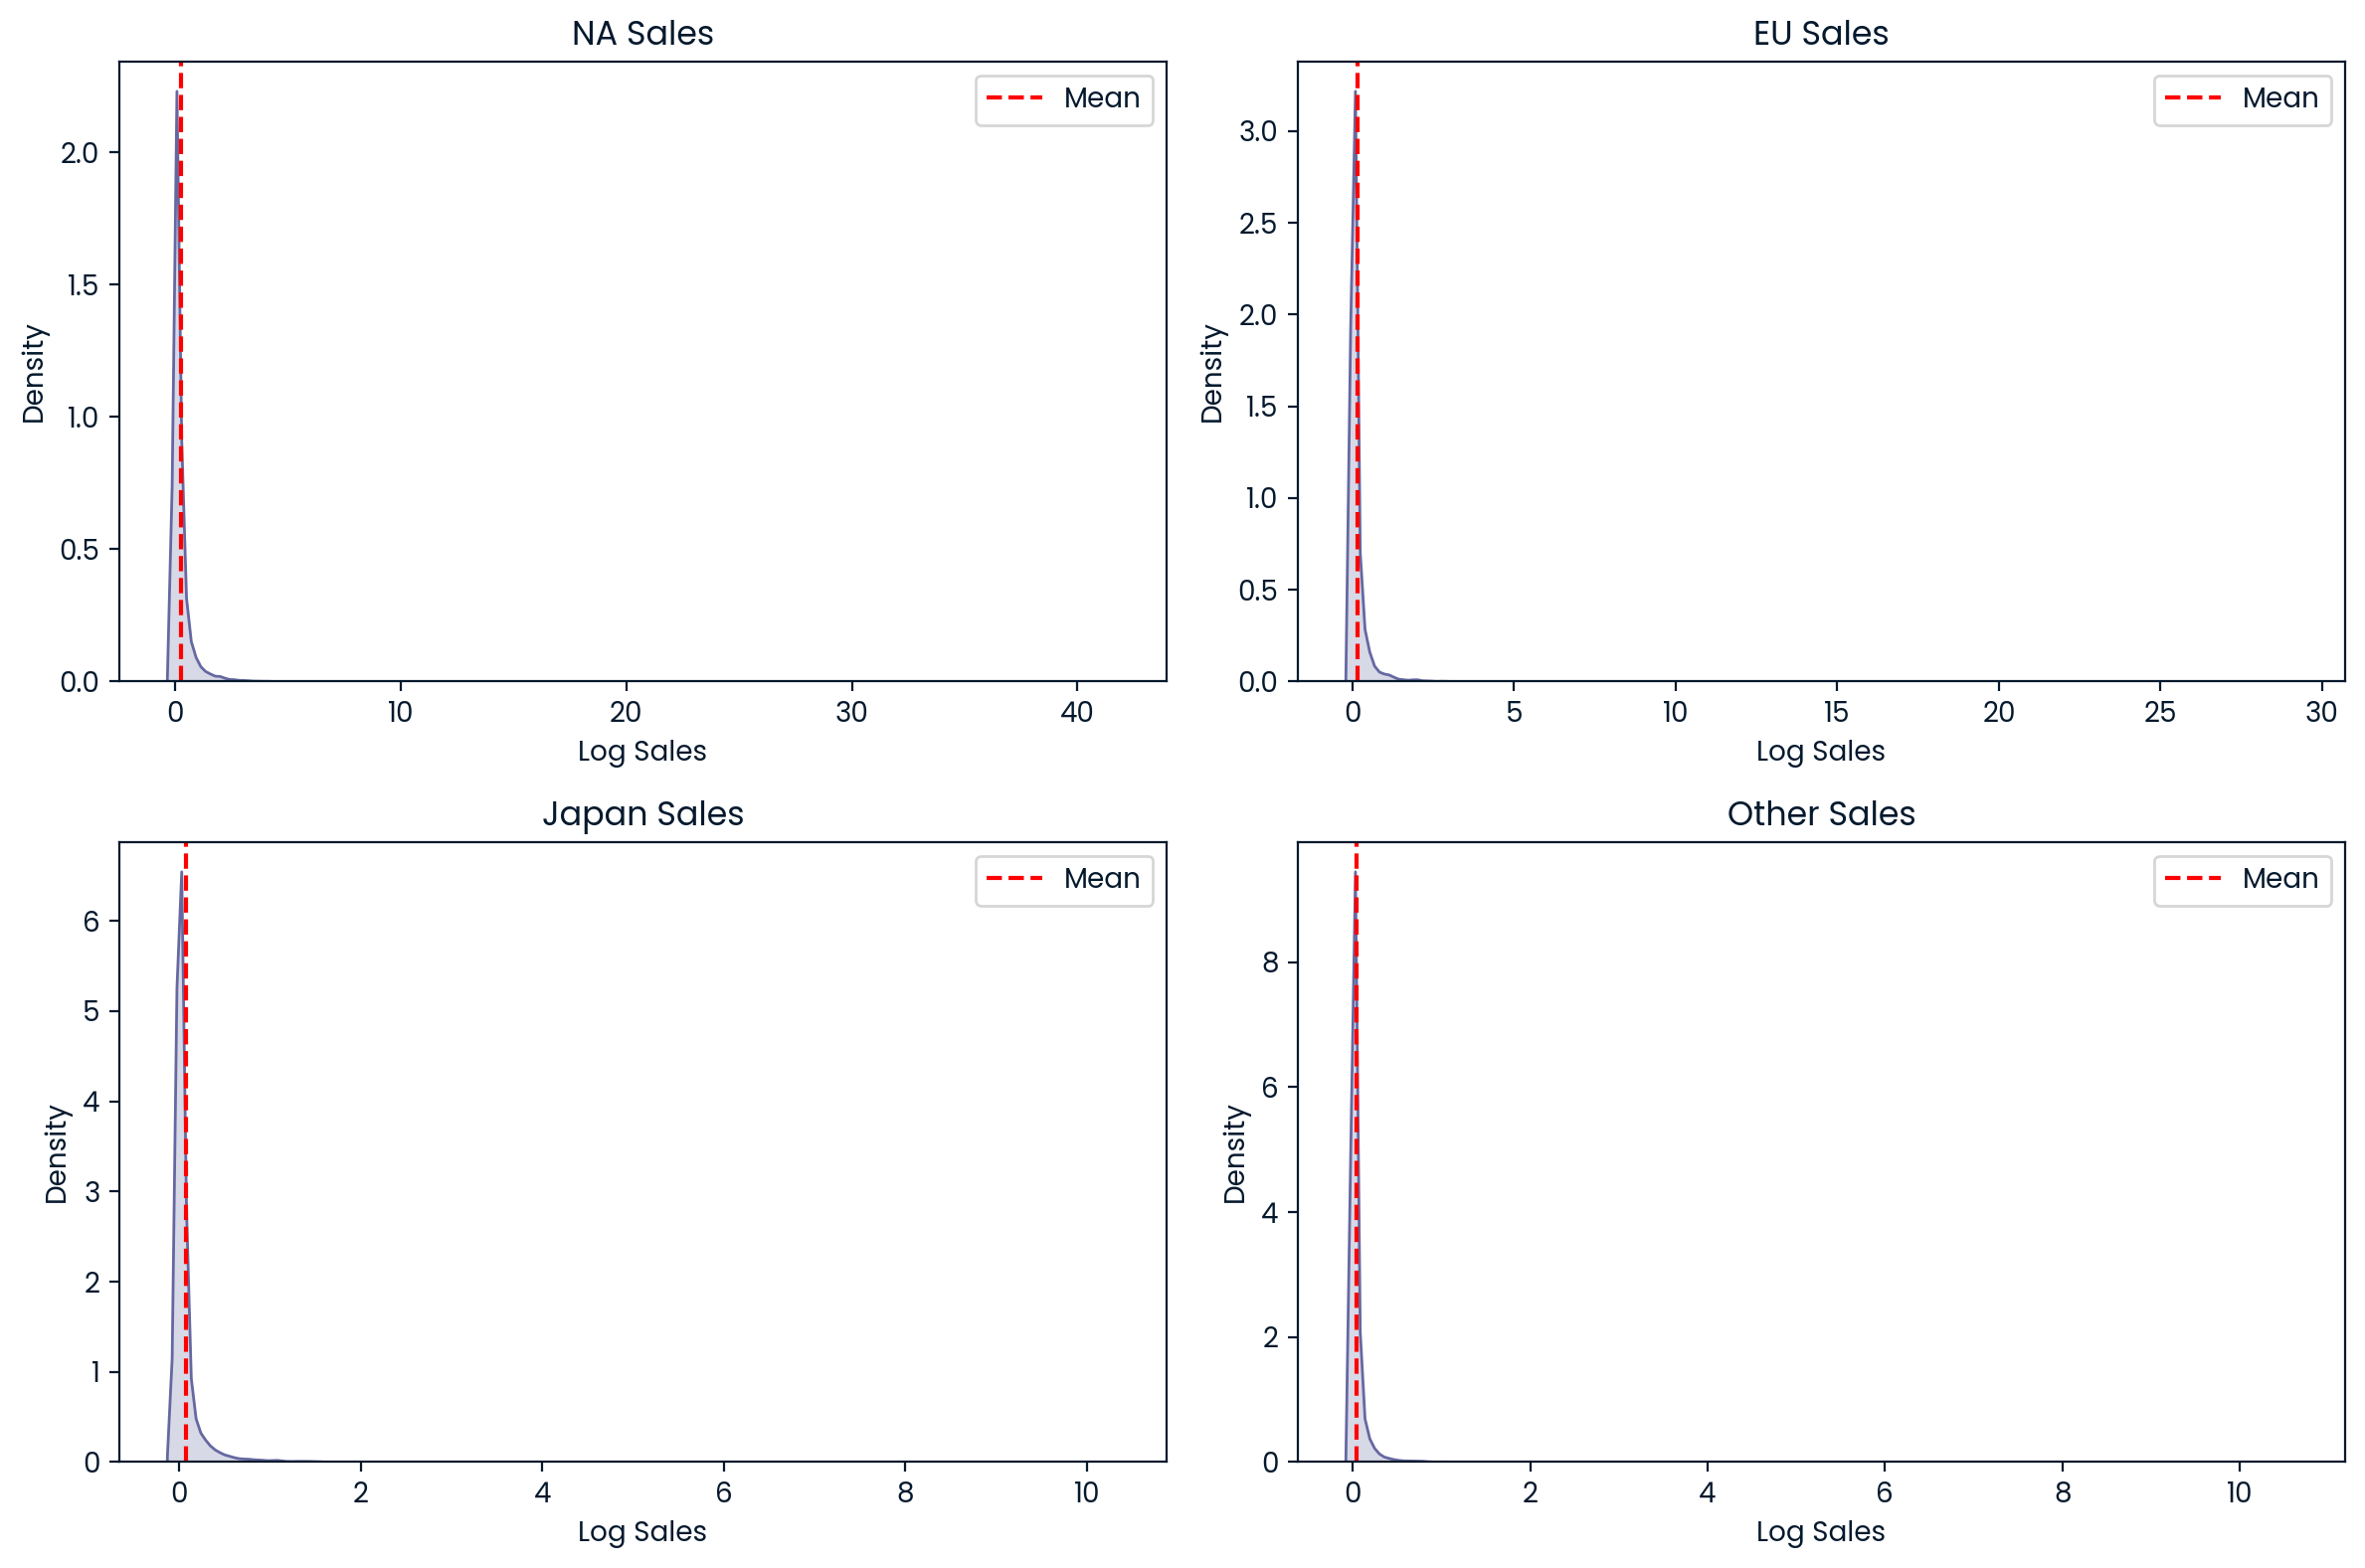

In [6]:
# Separate the data for each region
eu_sales = vgsales['EU_Sales']
na_sales = vgsales['NA_Sales']
jp_sales = vgsales['JP_Sales']
other_sales = vgsales['Other_Sales']

# Create a figure for the subplots
plt.figure(figsize=(12, 8))

# Generate kdeplot graphs for each region
plot_kde(na_sales, 'NA Sales', (2, 2, 1))
plot_kde(eu_sales, 'EU Sales', (2, 2, 2))
plot_kde(jp_sales, 'Japan Sales', (2, 2, 3))
plot_kde(other_sales, 'Other Sales', (2, 2, 4))

# Display the graphs
plt.tight_layout()
plt.show()



Assessing the data distribution and its mean, however, due to the skewed distribution, it's not easy to observe clearly, as there are titles that were extremely successful. Therefore, I will proceed to evaluate the distribution after scaling the data using a logarithmic transformation.

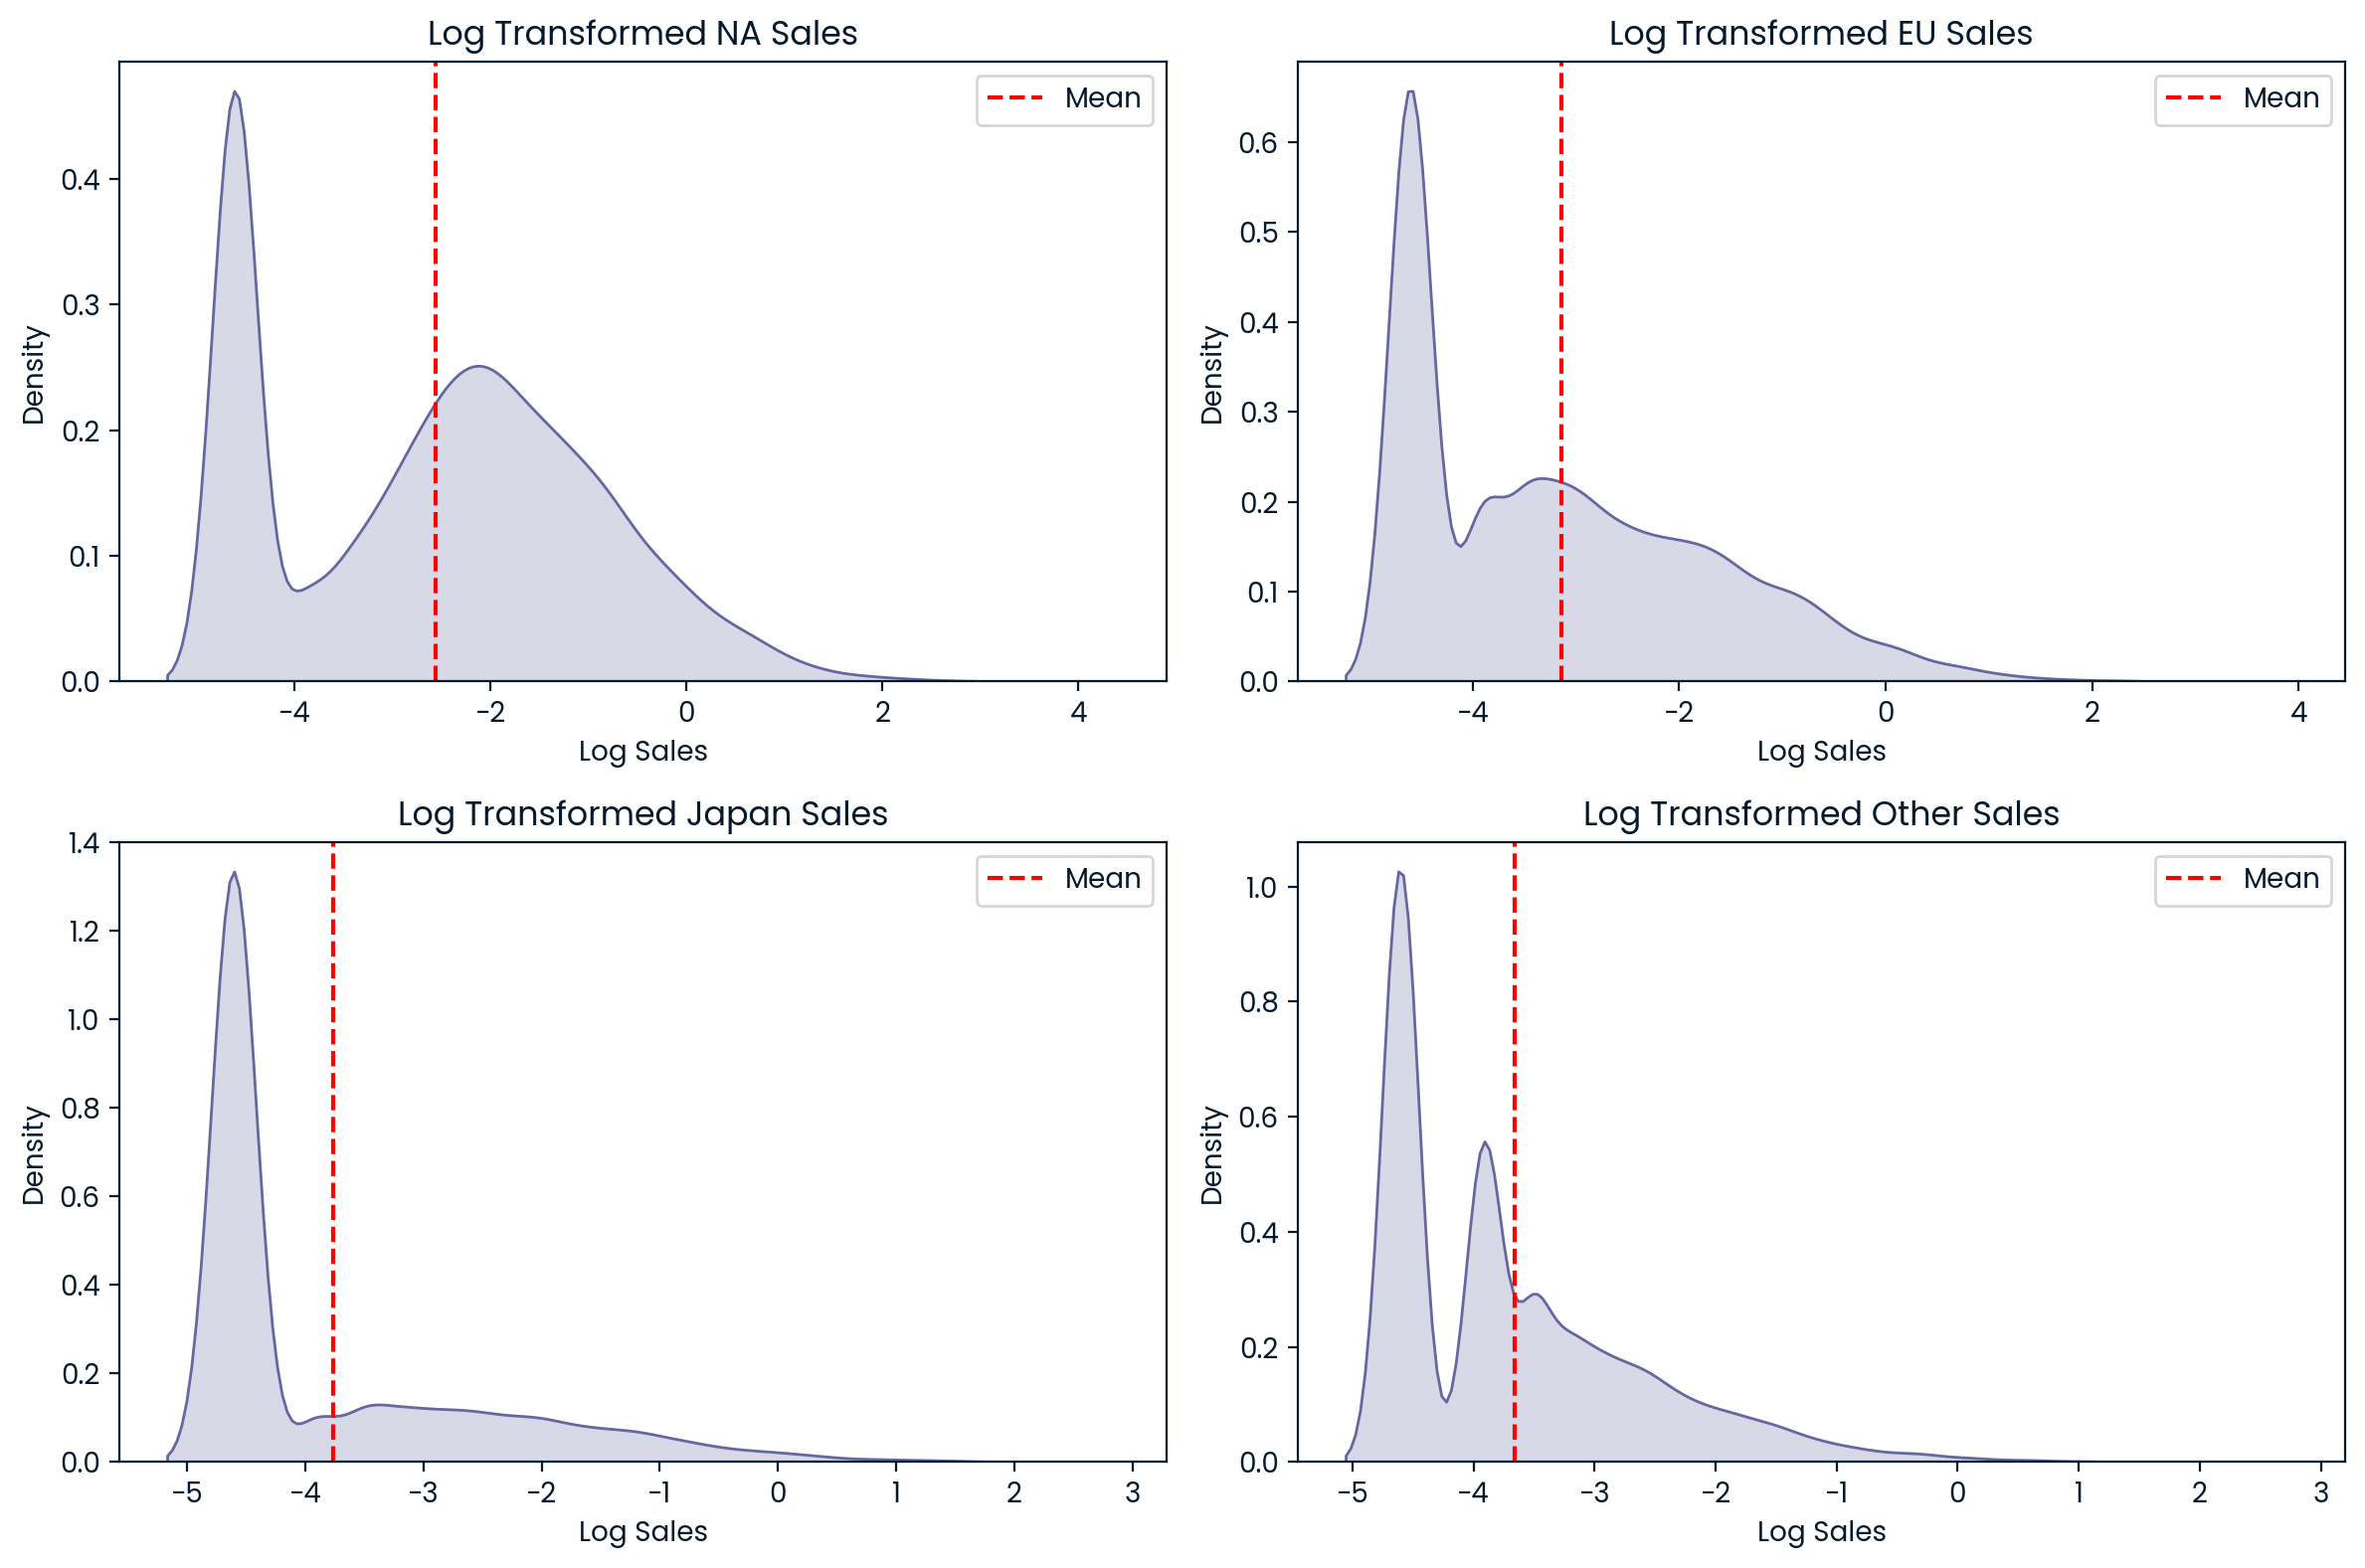

In [7]:
# Apply the logarithmic transformation
eu_sales_log = log_transform(eu_sales)
na_sales_log = log_transform(na_sales)
jp_sales_log = log_transform(jp_sales)
other_sales_log = log_transform(other_sales)

# Create a figure for the subplots
plt.figure(figsize=(12, 8))

# Generate kdeplot graphs for each region
plot_kde(na_sales_log, 'Log Transformed NA Sales', (2, 2, 1))
plot_kde(eu_sales_log, 'Log Transformed EU Sales', (2, 2, 2))
plot_kde(jp_sales_log, 'Log Transformed Japan Sales', (2, 2, 3))
plot_kde(other_sales_log, 'Log Transformed Other Sales', (2, 2, 4))

# Display the plots
plt.tight_layout()
plt.show()

Observing, as was expected from the previous graphs, it becomes evident that the data does not follow a normal distribution but rather a left-skewed distribution, even after scaling using a logarithmic transformation. Additionally, after evaluating the possible scaling methods to apply, I was deciding between using a _RobustScaler_ or a _LogTransform_. I will opt for the latter. While the outliers contain valuable information, I want to reduce the skew. Moreover, since the sales values are positive, applying a _LogTransform_ should not pose any issues. Additionally, before training the model, I will also apply normalization.

In [8]:
# Calculate the count for each publisher
publisher_counts = vgsales['Publisher'].value_counts()

# Calculate the cumulative sum of the counts
cumulative_sum = publisher_counts.cumsum()

# Calculate the total count of publishers
total_count = publisher_counts.sum()

# Find the index where the cumulative sum reaches 80% of the total count
index_80_percent = cumulative_sum[cumulative_sum <= 0.8 * total_count].index[-1]

# Filter the publishers that contribute to the top 80% of values
top_publishers = publisher_counts.loc[:index_80_percent]

# Count the number of categories
num_categories = len(top_publishers)

print(f'Number of publishers than group 80% of publications: {num_categories}')
print('Show top 10')
top_publishers[:10]


Number of publishers than group 80% of publications: 47
Show top 10


Electronic Arts                 1339
Activision                       966
Namco Bandai Games               928
Ubisoft                          918
Konami Digital Entertainment     823
THQ                              712
Nintendo                         696
Sony Computer Entertainment      682
Sega                             632
Take-Two Interactive             412
Name: Publisher, dtype: int64

It was evaluated using Pareto, and 47 publishers represent 80% of the releases (out of a total of 572 publishers). I will proceed to change the labels of those that are not in the top 80% to the category 'Others'.

In [9]:
# Create a new column 'Publisher_80' based on whether the publisher is in the top_publishers index
vgsales['Publisher_80'] = vgsales['Publisher'].apply(lambda x: x if x in top_publishers.index else 'Other')

In [10]:
vgsales.sample(10)

,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Publisher_80
Name,,,,,,,,,,
Jam Sessions 2,DS,2009.0,Misc,Ubisoft,0.06,0.00,0.00,0.00,0.06,Ubisoft
Power Rangers: Dino Thunder,GBA,2003.0,Action,THQ,0.35,0.13,0.00,0.01,0.49,THQ
Gauntlet Legends,PS,2000.0,Action,Midway Games,0.26,0.18,0.00,0.03,0.47,Midway Games
The King of Fighters XII,X360,2009.0,Fighting,Ignition Entertainment,0.09,0.00,0.01,0.01,0.11,Ignition Entertainment
Halo: Combat Evolved,PC,2003.0,Shooter,Microsoft Game Studios,0.01,0.02,0.00,0.01,0.04,Microsoft Game Studios
GA - Geijutsuka Art Design Class: Slapstick Wonder Land,PSP,2010.0,Adventure,Russel,0.00,0.00,0.02,0.00,0.02,Other
Hoshigami: Ruining Blue Earth Remix,DS,2007.0,Role-Playing,505 Games,0.00,0.00,0.01,0.00,0.01,505 Games
Carmen Sandiego: The Secret of the Stolen Drums,GC,2004.0,Action,BAM! Entertainment,0.02,0.00,0.00,0.00,0.02,Other
San Goku Shi Taisen Ten,DS,2008.0,Strategy,Sega,0.00,0.00,0.07,0.00,0.07,Sega


"I determine the following: the target, the numeric features (previously to apply log transform) to scale (I will not use Global_Sales to avoid multicollinearity), and the categorical features for one-hot encoding. Instead of Publisher (with 572 unique values), I will use Publisher_80 (with 48 unique values).
1. One-hot encoding
2. Split data
3. Scaling

In [11]:
vgsales.columns

Index(['Platform', 'Year', 'Genre', 'Publisher', 'NA_Sales', 'EU_Sales',
       'JP_Sales', 'Other_Sales', 'Global_Sales', 'Publisher_80'],
      dtype='object')

In [12]:
# Import modules
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline

In [13]:
# Only with numeric features
target = vgsales['JP_Sales']

features_numeric = pd.concat((vgsales['Year'],na_sales,eu_sales,other_sales),axis=1)
X_train, X_test, y_train, y_test = train_test_split(features_numeric, target, test_size=0.2, random_state=42)

# Create an instance of MinMaxScaler for features
scaler_X_numeric = MinMaxScaler()

# Fit the scaler to the features and transform
X_train_scaled_numeric = scaler_X_numeric.fit_transform(X_train)
X_test_scaled_numeric = scaler_X_numeric.transform(X_test)

# Create an instance of MinMaxScaler for target
scaler_y = MinMaxScaler()

# Since the target is a single column, it needs to be reshaped for MinMaxScaler
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

print(features_numeric.shape, target.shape)

# Define a pipeline to search for the best combination of model preprocessing and model
pipe_numeric = Pipeline([
    ('model', LinearRegression())  # Placeholder for the model
])

# Define the model space
model_space_numeric = [
    {'model': [Lasso()], 'model__alpha': [0.01, 0.1, 1, 10, 100]},
    {'model': [Ridge()], 'model__alpha': [0.01, 0.1, 1, 10, 100]},
    {'model': [LinearRegression()]},
    {'model': [SVR()], 'model__C': [0.1, 1, 10], 'model__kernel': ['linear', 'rbf']},
    {'model': [DecisionTreeRegressor()], 'model__max_depth': [None, 2, 5, 10, 20], 'model__min_samples_leaf': [1, 2, 5]}
]

# Create the GridSearchCV object
grid_search_numeric = GridSearchCV(pipe_numeric, model_space_numeric, cv=5, scoring='neg_mean_squared_error')

# Fit the model
grid_search_numeric.fit(X_train_scaled_numeric, y_train_scaled.ravel())

# Print the best parameters and the best model
print("Best parameters:", grid_search_numeric.best_params_)
print("Best model:", grid_search_numeric.best_estimator_)
best_model_score_numeric = grid_search_numeric.best_estimator_.score(X_test_scaled_numeric, y_test_scaled)
print(best_model_score_numeric)


(16290, 4) (16290,)
Best parameters: {'model': DecisionTreeRegressor(max_depth=10, min_samples_leaf=5), 'model__max_depth': 10, 'model__min_samples_leaf': 5}
Best model: Pipeline(steps=[('model',
                 DecisionTreeRegressor(max_depth=10, min_samples_leaf=5))])
0.21238062161073223


After testing the grid search using the 'Year' column, a score improvement of 0.02 was achieved when evaluating the best model.

In [14]:
# One-hot encoding
features_categoric_onethot = pd.get_dummies(vgsales[['Publisher_80']])
features_categoric_dummy = pd.get_dummies(vgsales[['Platform','Genre']], drop_first=True)
features_concat = pd.concat((features_numeric,features_categoric_dummy,features_categoric_onethot),axis=1)

print(features_concat.shape, target.shape)

# Split one-hot encoding data
X_train, X_test, y_train, y_test = train_test_split(features_concat, target, test_size=0.2, random_state=42)

# Create an instance of MinMaxScaler for features
scaler_X = MinMaxScaler()

# Fit the scaler to the features and transform
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Define a pipeline to search for the best combination of model preprocessing and model
pipe = Pipeline([
    ('model', LinearRegression())  # Placeholder for the model
])

# Define the model space
model_space_onehot = [
    {'model': [Lasso()], 'model__alpha': [0.01, 0.1, 1, 10, 100]},
    {'model': [Ridge()], 'model__alpha': [0.01, 0.1, 1, 10, 100]},
    {'model': [LinearRegression()]},
    {'model': [SVR()], 'model__C': [0.1, 1, 10], 'model__kernel': ['linear', 'rbf']},
    {'model': [DecisionTreeRegressor()], 'model__max_depth': [None, 2, 5, 10, 20], 'model__min_samples_leaf': [1, 2, 5]}
]

# Create the GridSearchCV object
grid_search_onehot = GridSearchCV(pipe, model_space_onehot, cv=5, scoring='neg_mean_squared_error')

# Fit the model
grid_search_onehot.fit(X_train_scaled, y_train_scaled.ravel())

# Print the best parameters and the best model
print("Best parameters:", grid_search_onehot.best_params_)
print("Best model:", grid_search_onehot.best_estimator_)

# Print score best model with one-hot encoding
best_model_score_onehot = grid_search_onehot.best_estimator_.score(X_test_scaled, y_test_scaled)
print(best_model_score_onehot)

(16290, 93) (16290,)
Best parameters: {'model': DecisionTreeRegressor(min_samples_leaf=5), 'model__max_depth': None, 'model__min_samples_leaf': 5}
Best model: Pipeline(steps=[('model', DecisionTreeRegressor(min_samples_leaf=5))])
0.5206196437768889


Just like in the model with only numerical features, after trying without using the 'Year' column and using it, I obtained a better result using the 'Year' column.

Also, using the sales columns, I got a better result using the original columns as input data instead of the transformed ones with log_transform.

### Ramdom Forest Regressor

In [15]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint

# Define the parameter grid to use for the RandomizedSearch
param_dist = {
    "n_estimators": randint(100, 500),
    "max_depth": randint(3, 10),
    "min_samples_split": randint(2, 11),
    "min_samples_leaf": randint(1, 11),
    "bootstrap": [True, False]
}

# Initialize the RandomForestRegressor
forest_reg = RandomForestRegressor()

# Initialize the RandomizedSearchCV object
random_search = RandomizedSearchCV(forest_reg, param_distributions=param_dist, n_iter=10, cv=5, verbose=0, n_jobs=-1, random_state=42)

# Fit the model
random_search.fit(X_train_scaled, y_train_scaled.ravel())

# Print the best parameters and the best model
print("Best Parameters:", random_search.best_params_)
print("Best Model:", random_search.best_estimator_)

# Print score best model with one-hot encoding
best_model_score_forest = random_search.best_estimator_.score(X_test_scaled, y_test_scaled)
print(best_model_score_forest)

Best Parameters: {'bootstrap': True, 'max_depth': 7, 'min_samples_leaf': 9, 'min_samples_split': 8, 'n_estimators': 373}
Best Model: RandomForestRegressor(max_depth=7, min_samples_leaf=9, min_samples_split=8,
                      n_estimators=373)
0.5841631517175441


### Gradient Boosting Regressor

In [16]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Create model Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42)

# Define hiperparams
param_grid_gradbost = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [2, 4]
}

# Apply GridSearchCV
gbr_grid = GridSearchCV(estimator=gbr, param_grid=param_grid_gradbost, cv=3, n_jobs=-1, verbose=0)
gbr_grid.fit(X_train_scaled, y_train_scaled.ravel())

# Print the best parameters and the best model
print("Best parameters:", gbr_grid.best_params_)
print("Best model:", gbr_grid.best_estimator_)

# Print score best model with one-hot encoding
best_model_score_gbr = gbr_grid.best_estimator_.score(X_test_scaled, y_test_scaled)
print(best_model_score_gbr)


Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best model: GradientBoostingRegressor(min_samples_leaf=2, n_estimators=300, random_state=42)
0.654891703409142


### XGBoosT

In [17]:
from xgboost import XGBRegressor

# Create model XGBoost Regressor
xgb = XGBRegressor(random_state=42)

# Define hiperparams
param_grid_xgb = {
    'n_estimators': [200, 300],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9]
}

# Apply GridSearchCV
xgb_grid = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=3, n_jobs=-1, verbose=0)
xgb_grid.fit(X_train_scaled, y_train_scaled.ravel())

# Print the best parameters and the best model
print("Best parameters:", xgb_grid.best_params_)
print("Best model:", xgb_grid.best_estimator_)

# Print score best model with one-hot encoding
best_model_score_xgb = xgb_grid.best_estimator_.score(X_test_scaled, y_test_scaled)
print(best_model_score_xgb)


Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300, 'subsample': 0.7}
Best model: XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=300, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)
0.6767811366374161


## Conclusions:

- After trying different machine learning models for regression, the best score (R^2) was obtained with the XGB Regressor, yielding a score of 0.6767
- Results were improved by including the 'Year' column.
- Applying log transform to the numerical features (the training data that included one-hot encoding) resulted in worse performance in the models, with the score being similar to using only the numerical features as training data (without the categorical features).
- Using only the numerical features led to lower performance in the model with a score of 0.2124.
- Including the categorical feature 'Publisher' improved the model, although to a minimal extent.

### Observations:
- I did not use the numerical feature 'Global Sales' because it represents the total sum of sales. Therefore, the model could be fitted with an R^2 above 99%, but this fit would not be very useful since 'Global_Sales' already includes 'JP_Sales' and cannot be calculated before 'JP_Sales' values are available. This would lead to a misleading perception of good model fit. 'Global_Sales' can be manually inferred by subtracting the sum of the other numerical sales features.
- Due to the high dimensionality that would be generated by the 'Publisher' feature, I decided to apply Pareto and classify the 20% grouping the fewest publications as 'Othe- 

### Recommendations:
- Change the encoding method for 'Publisher'. Instead of using Pareto 80-20 and one-hot encoding, consider using 'Frequency Encoding'. This approach may improve the model by incorporating more parameters, as the 'Publisher' grouped as 'Others' could provide more information to the model.